# Embedding Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/customers_100k.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   account_id                       100000 non-null  object 
 1   country_name                     100000 non-null  object 
 2   account_category                 100000 non-null  object 
 3   bi_account_classification        100000 non-null  object 
 4   customer_type                    100000 non-null  object 
 5   region                           100000 non-null  object 
 6   sic_code                         100000 non-null  int64  
 7   employee_number                  100000 non-null  int64  
 8   revenue_in_eur                   100000 non-null  float64
 9   number_distinct_active_licenses  100000 non-null  int64  
 10  major_edition                    100000 non-null  object 
 11  total_connections_12m            100000 non-null  int64  
 12  tot

In [4]:
df.head(10)

,account_id,country_name,account_category,bi_account_classification,customer_type,region,sic_code,employee_number,revenue_in_eur,number_distinct_active_licenses,...,total_connections_12m,total_endpoints_12m,total_devices_12m,last_invoice_date_created,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,business_model
0,ac6a99474410f1c59c91da3f0cf9cf3f,Tonga,Standard,Inside Sales,Customer,APAC,7381,8,1502000.0,1,...,54,4,2,2023-11-23 01:57:47,Webshop,6,5,2532.84,466.47,S
1,1cc66628ed41f3db5a55195e93277a04,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,5049,11,1814000.0,1,...,3385,158,51,2023-10-07 19:35:11,Webshop,1,0,1298.15,972.57,S
2,db5f3cdd5629b9591b720b9b7e077df2,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,7389,16,13444000.0,1,...,12,2,2,2023-12-02 02:03:05,Webshop,2,1,155.83,76.69,S
3,bebb4028688f519f36ed220855b0a62f,Costa Rica,Standard,Reseller,End-User Reseller,AMERICAS,8711,36,7066000.0,3,...,1724,206,30,2023-10-25 23:32:46,Inside Sales,7,5,7550.16,1088.58,S
4,507c0bfb67895d773e3f8bd33b861d09,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,6531,312,61054000.0,2,...,6493,611,31,2023-11-17 04:16:51,Inside Sales,10,1,4688.33,1593.70,S
5,b1267a5b953b7267de811510f838172b,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,5943,25,4881000.0,1,...,583,3,5,2023-08-21 01:11:38,Webshop,5,4,971.96,198.63,S
6,3315ad169d4d2e9080f1377c44377c7c,Costa Rica,Standard,Reseller,Reseller,AMERICAS,7378,15,3013000.0,9,...,2181,311,7,2023-09-28 04:27:43,Reseller,7,15,66581.67,837.31,S
7,8ca7b69eda1a06b32e60fff1c6db3b28,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,1,717,159214000.0,1,...,2415,244,4,2023-12-22 06:27:18,Other,12,6,2986.48,211.88,S
8,5bd2eea4e2320b9246b41a8f54fb02d2,Costa Rica,SMB,Inside Sales,Customer,AMERICAS,8111,5,934000.0,3,...,22037,3766,1311,2023-09-22 01:48:17,Inside Sales,9,4,46022.86,9129.48,S
9,bbfb03bca60fb0185be3f36d12c99b3f,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,8731,22,4308000.0,2,...,4064,672,15,2023-12-20 01:21:26,Inside Sales,15,4,12584.99,1308.89,S


## Data Preprocessing

In [5]:
df.drop(columns=['business_model', 'last_invoice_date_created'], inplace=True)

In [6]:
# Define a dictionary to map SIC code ranges to major industry groups
major_groups = {
    range(1, 10): 'Agriculture, Forestry, and Fishing',
    range(10, 15): 'Mining',
    range(15, 18): 'Construction',
    range(20, 40): 'Manufacturing',
    range(40, 50): 'Transportation, Communications, Electric, Gas, and Sanitary Services',
    range(50, 52): 'Wholesale Trade',
    range(52, 60): 'Retail Trade',
    range(60, 68): 'Finance, Insurance, and Real Estate',
    range(70, 90): 'Services',
    range(90, 100): 'Public Administration'
}

# Map SIC code ranges to major industry group descriptions
def map_to_major_group(sic_code):
    for group_range, description in major_groups.items():
        if sic_code // 100 in group_range:
            return description
    return 'Unknown'

In [7]:
df['industry'] = df['sic_code'].apply(map_to_major_group)
df.drop(columns=['account_id','country_name','sic_code'], inplace=True)

In [8]:
df.head(10)

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry
0,Standard,Inside Sales,Customer,APAC,8,1502000.0,1,Business,54,4,2,Webshop,6,5,2532.84,466.47,Services
1,Standard,Inside Sales,Customer,AMERICAS,11,1814000.0,1,Premium,3385,158,51,Webshop,1,0,1298.15,972.57,Wholesale Trade
2,Standard,Inside Sales,Customer,AMERICAS,16,13444000.0,1,Remote Access,12,2,2,Webshop,2,1,155.83,76.69,Services
3,Standard,Reseller,End-User Reseller,AMERICAS,36,7066000.0,3,Corporate,1724,206,30,Inside Sales,7,5,7550.16,1088.58,Services
4,Standard,Inside Sales,Customer,AMERICAS,312,61054000.0,2,Corporate,6493,611,31,Inside Sales,10,1,4688.33,1593.70,"Finance, Insurance, and Real Estate"
5,Standard,Inside Sales,Customer,AMERICAS,25,4881000.0,1,Remote Access,583,3,5,Webshop,5,4,971.96,198.63,Retail Trade
6,Standard,Reseller,Reseller,AMERICAS,15,3013000.0,9,Corporate,2181,311,7,Reseller,7,15,66581.67,837.31,Services
7,Standard,Inside Sales,Customer,AMERICAS,717,159214000.0,1,Business,2415,244,4,Other,12,6,2986.48,211.88,Unknown
8,SMB,Inside Sales,Customer,AMERICAS,5,934000.0,3,Corporate,22037,3766,1311,Inside Sales,9,4,46022.86,9129.48,Services
9,Standard,Inside Sales,Customer,AMERICAS,22,4308000.0,2,Corporate,4064,672,15,Inside Sales,15,4,12584.99,1308.89,Services


In [9]:
# Preprocess the data

# Separate numeric and categorical columns
cat_cols = ['account_category', 'bi_account_classification', 'customer_type', 
            'region', 'major_edition', 'current_sales_channel', 'industry']

num_cols = [col for col in df.columns if col not in cat_cols]

In [28]:
df_cols = num_cols + cat_cols

In [29]:
df_cols

['employee_number',
 'revenue_in_eur',
 'number_distinct_active_licenses',
 'total_connections_12m',
 'total_endpoints_12m',
 'total_devices_12m',
 'age_customer',
 'number_renewals',
 'account_value_in_eur',
 'billings_ltm_prorated',
 'account_category',
 'bi_account_classification',
 'customer_type',
 'region',
 'major_edition',
 'current_sales_channel',
 'industry']

In [11]:
# Preprocess numeric data
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Preprocess categorical data
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [12]:
# Calculate the number of unique values for each categorical column
cat_vocab_sizes = {col: df[col].nunique() for col in cat_cols}
print(cat_vocab_sizes)

{'account_category': 5, 'bi_account_classification': 5, 'customer_type': 4, 'region': 3, 'major_edition': 6, 'current_sales_channel': 6, 'industry': 11}


## Feature-Tokenizer Transformer (FT-Transformer) Model

In [13]:
# Create custom Dataset class
class TabularDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.cat_data = df[cat_cols].values
        self.num_data = df[num_cols].values
        
    def __len__(self):
        return len(self.cat_data)
    
    def __getitem__(self, idx):
        cat_feats = torch.tensor(self.cat_data[idx], dtype=torch.long)
        num_feats = torch.tensor(self.num_data[idx], dtype=torch.float)
        return cat_feats, num_feats

In [14]:
dataset = TabularDataset(df, cat_cols, num_cols)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [15]:
# Define FTTransformer model
class FTTransformer(nn.Module):
    def __init__(self, num_categorical_features, num_numerical_features, cat_vocab_sizes, cat_embed_dims, num_heads, num_layers, d_model, hidden_dim, dropout):
        super(FTTransformer, self).__init__()
        
        # Embedding layers for categorical features
        self.cat_embed_layers = nn.ModuleList([
            nn.Embedding(num_embeddings=cat_vocab_sizes[i], embedding_dim=cat_embed_dims[i]) for i in range(num_categorical_features)
        ])
        
        # Linear layer for numerical features
        self.num_linear_layer = nn.Linear(num_numerical_features, d_model - sum(cat_embed_dims))
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer for CLS token representation (not used in clustering)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Learnable parameter for CLS token
    
    def forward(self, cat_feats, num_feats):
        # Embed categorical features
        cat_embeds = [embed(cat_feats[:, i]) for i, embed in enumerate(self.cat_embed_layers)]
        cat_embeds = torch.cat(cat_embeds, dim=-1)
        
        # Linear transformation of numerical features
        num_embeds = self.num_linear_layer(num_feats)
        
        # Combine embeddings
        combined_embeds = torch.cat([cat_embeds, num_embeds], dim=-1)
        
        # Add positional encoding if needed
        combined_embeds = combined_embeds.unsqueeze(1)  # (batch_size, seq_len=1, d_model)
        
        # Transformer encoding
        encoded_output = self.transformer_encoder(combined_embeds)
        
        return encoded_output.squeeze(1)  # Return the encoded output for clustering

In [16]:
# Check if CUDA is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [17]:
# Define vocabulary sizes and embedding dimensions based on provided dictionary
cat_vocab_sizes = [5, 5, 4, 3, 6, 6, 11]
cat_embed_dims = [4, 4, 3, 3, 4, 4, 5] # Manually set to ensure sum(cat_embed_dims) + d_num = d_model 

# cat_embed_dims = [int(np.sqrt(vocab_size)) for vocab_size in cat_vocab_sizes]

# Calculate d_model and d_num to match
d_model = 32
d_num = d_model - sum(cat_embed_dims)

In [18]:
# Instantiate the model and move it to the appropriate device
model = FTTransformer(
    num_categorical_features=len(cat_cols), 
    num_numerical_features=len(num_cols), 
    cat_vocab_sizes=cat_vocab_sizes,
    cat_embed_dims=cat_embed_dims,
    num_heads=4,
    num_layers=2,
    d_model=d_model,
    hidden_dim=64,
    dropout=0.2
)
model.to(device)

FTTransformer(
  (cat_embed_layers): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(3, 3)
    (4): Embedding(6, 4)
    (5): Embedding(6, 4)
    (6): Embedding(11, 5)
  )
  (num_linear_layer): Linear(in_features=10, out_features=5, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      

In [19]:
# Training loop (skipped for clustering task)
# For clustering, we would typically directly use the embeddings for clustering

# Example of clustering with embeddings
model.eval()
embeddings_list = []
with torch.no_grad():
    for cat_feats, num_feats in loader:
        cat_feats, num_feats = cat_feats.to(device), num_feats.to(device)
        embeddings = model(cat_feats, num_feats)
        embeddings_list.append(embeddings.cpu().numpy())
embeddings = np.vstack(embeddings_list)

## Determine the number of clusters(k)

In [20]:
# Define a range of k values to test
k_range = range(1, 30)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19
Now on k 20
Now on k 21
Now on k 22
Now on k 23
Now on k 24
Now on k 25
Now on k 26
Now on k 27
Now on k 28
Now on k 29


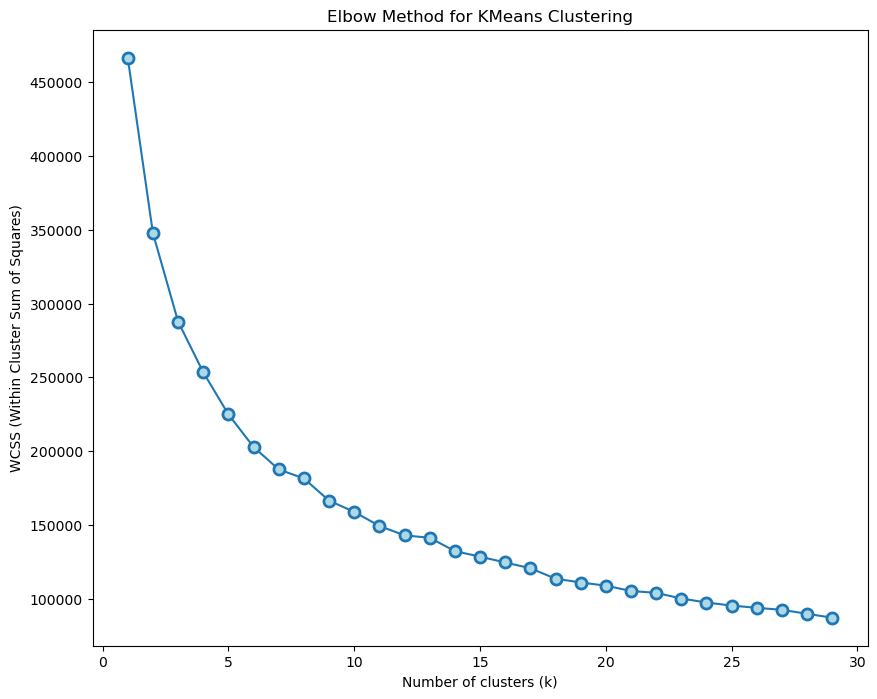

In [21]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [24]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=7, random_state=0).fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(embeddings)
df.groupby(['cluster_kmeans']).mean()

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry
cluster_kmeans,,,,,,,,,,,,,,,,,
0,3.961515,1.146209,0.059098,1.606929,0.000568,0.000265,0.004154,1.356450,0.001555,0.002394,0.001527,2.676279,0.318597,0.017812,0.002235,0.001500,5.767118
1,3.958516,1.154986,0.064545,1.615563,0.000646,0.000349,0.004108,1.349781,0.001626,0.002496,0.001529,2.693893,0.313852,0.017702,0.002257,0.001529,5.817573
2,3.952571,1.142645,0.060089,1.612779,0.000545,0.000274,0.004158,1.347994,0.001552,0.002300,0.001493,2.675186,0.319983,0.017824,0.002279,0.001505,5.768737
3,3.951321,1.144407,0.060645,1.613982,0.000452,0.000269,0.004235,1.335149,0.001699,0.002415,0.001648,2.674423,0.320281,0.017886,0.002407,0.001629,5.819543
4,3.959123,1.156252,0.063841,1.613949,0.000572,0.000304,0.004186,1.366838,0.001663,0.002427,0.001615,2.686646,0.318822,0.017766,0.002334,0.001576,5.732176
5,3.964370,1.152199,0.061683,1.607764,0.000448,0.000269,0.004254,1.370714,0.001506,0.002358,0.001500,2.702605,0.320316,0.018154,0.002328,0.001593,5.775512
6,3.959285,1.145373,0.060625,1.605488,0.000683,0.000296,0.004247,1.385195,0.001590,0.002373,0.001513,2.674154,0.318083,0.017717,0.002363,0.001641,5.784301


In [ ]:
# df.mean()

In [25]:
df.cluster_kmeans.value_counts()

4    19987
3    19639
0    18241
2    16825
5     9711
6     7835
1     7762
Name: cluster_kmeans, dtype: int64

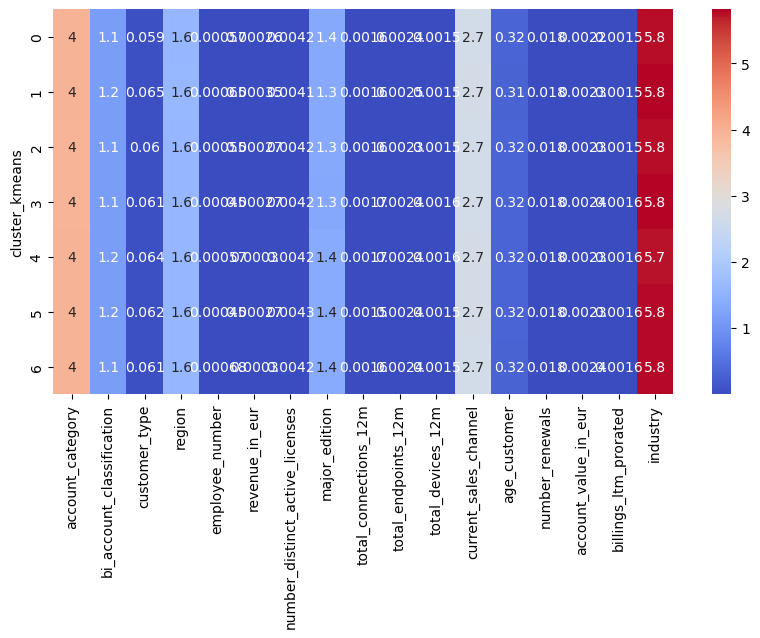

In [26]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [ ]:
clusters=pd.DataFrame(df_cols, columns=df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

NameError: name 'features' is not defined

ValueError: Shape of passed values is (17, 1), indices imply (17, 18)

## Evaluation

In [62]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.374


In [63]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 1.062


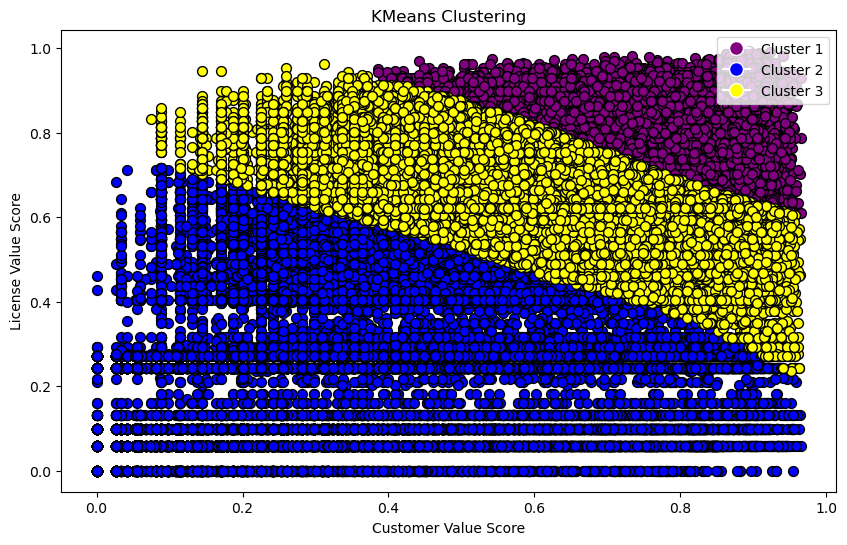

In [67]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Scatter plot of the data points
# plt.scatter(score_features[:, -2], score_features[:, -1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Scatter plot of the cluster centers
# plt.scatter(cluster_centers[:, -2], cluster_centers[:, -1], c='red', marker='x', s=200, linewidths=3, edgecolor='k', label='Cluster Centers')

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]
# legend_elements.append(Line2D([0], [0], marker='x', color='w', label='Cluster Centers', 
#                               markerfacecolor='red', markersize=10, linestyle='None', markeredgewidth=2))

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()